In [36]:
import torch.nn as nn
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import random

In [37]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
set_seed(42)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [39]:
dataset_S = dict()
dataset_F = dict()
dataset_FA = dict()

ks = [int(k) for k in os.listdir('../LIG_data/two_length')]

# 데이터셋 로드
for k in ks:
    data = torch.load(f"../LIG_data/two_length/{k}/gcn_dataset_full.pth", weights_only=False)
    dataset_S[k] = data["dataset_S"]
    dataset_F[k] = data["dataset_F"]
    dataset_FA[k] = data["dataset_FA"]

print("Datasets loaded successfully")


Datasets loaded successfully


In [40]:
for k in ks:
    print(f"Dataset for k={k}:")
    print(f"  dataset_S size: {dataset_S[k].size() if isinstance(dataset_S[k], torch.Tensor) else len(dataset_S[k])}")
    print(f"  dataset_F size: {dataset_F[k].size() if isinstance(dataset_F[k], torch.Tensor) else len(dataset_F[k])}")
    print(f"  dataset_FA size: {dataset_FA[k].size() if isinstance(dataset_FA[k], torch.Tensor) else len(dataset_FA[k])}")

Dataset for k=5:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=8:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=7:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=2:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=4:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=1:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=9:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=6:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014
Dataset for k=3:
  dataset_S size: 1014
  dataset_F size: 1014
  dataset_FA size: 1014


In [41]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p, num_layers):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.convs = torch.nn.ModuleList([
            GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 2)
        ])
        self.conv_out = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout_p = dropout_p

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout_p, training=self.training)
        x = self.conv_out(x, edge_index, edge_weight)
        x = global_mean_pool(x, batch) 
        x = self.fc(x)
        return x

In [42]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        if out.dim() == 2 and out.size(1) == 1:
            out = out.view(-1)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data).squeeze()
        pred = (torch.sigmoid(out) >= 0.5).int()
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def get_baseline_acc(loader):
    num_true = 0
    for data in loader:
        num_true += int(data.y.sum())
    return num_true / len(loader.dataset)

def test_with_auc(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            if out.dim() == 2 and out.size(1) == 1:
                out = out.view(-1)

            preds = torch.sigmoid(out).cpu().numpy()
            
            labels = data.y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    return fpr, tpr, auc

def evaluate_with_fixed_threshold_precision(model, loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            if out.dim() == 2 and out.size(1) == 1:
                out = out.view(-1)
                
            pred = (torch.sigmoid(out) >= threshold).int()

            if pred.ndim == 0:
                pred = torch.tensor(pred.item())
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)

    precision = precision_score(all_labels, all_preds, zero_division=0)
    
    return precision

def evaluate_with_fixed_threshold_recall(model, loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            if out.dim() == 2 and out.size(1) == 1:
                out = out.view(-1)
            pred = (torch.sigmoid(out) >= threshold).int()
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)
    
    recall = recall_score(all_labels, all_preds, zero_division=0)
    
    return recall

def evaluate_with_npv(model, loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            if out.dim() == 2 and out.size(1) == 1:
                out = out.view(-1)
            pred = (torch.sigmoid(out) >= threshold).int()
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)
    
    # Confusion matrix에서 True Negative와 False Negative 값을 추출
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    
    # Negative Predictive Value (NPV) 계산
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # 나누는 값이 0이 아닐 경우에만 계산
    
    return npv

def evaluate_with_specificity(model, loader):
    threshold = 0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            if out.dim() == 2 and out.size(1) == 1:
                out = out.view(-1)
            pred = (torch.sigmoid(out) >= threshold).int()
            labels = data.y.cpu().numpy()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels)
    
    # Confusion matrix에서 True Negative와 False Positive 값을 추출
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    
    # Specificity (True Negative Rate) 계산
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # 나누는 값이 0이 아닐 경우에만 계산
    
    return specificity

In [43]:
criterion = nn.BCEWithLogitsLoss()
output_dim = 1
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lr = 0.001
batch_size = 32
hidden_dim = 32
dropout_p = 0.8
num_layer = 2
num_epochs = 100

### Shape Only (S)

==================For 1=======================


5it [04:14, 50.98s/it]


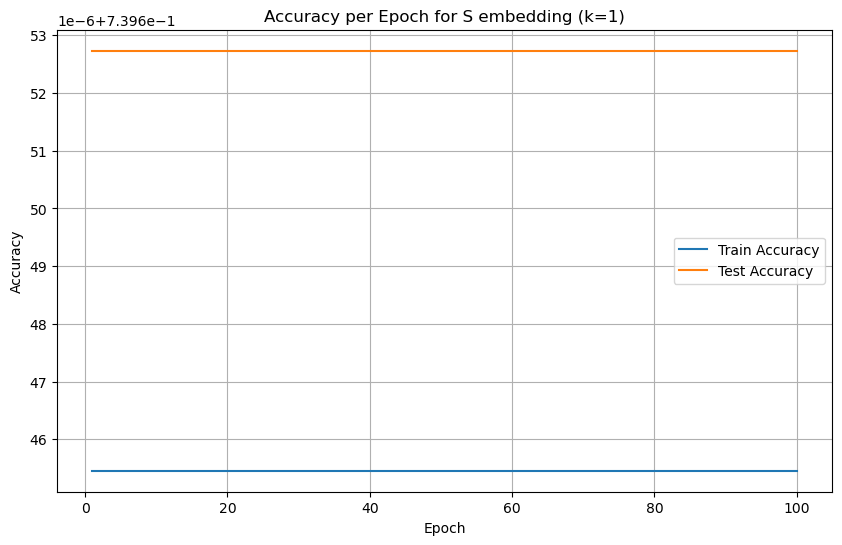

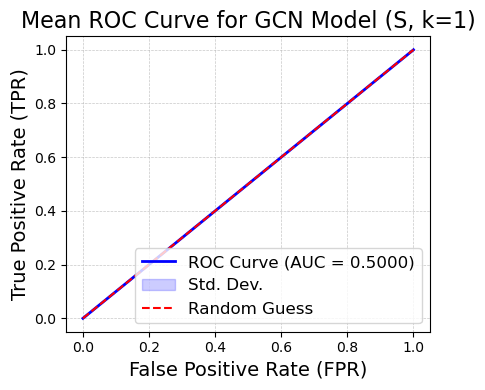

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5000
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 2=======================


5it [07:30, 90.02s/it]


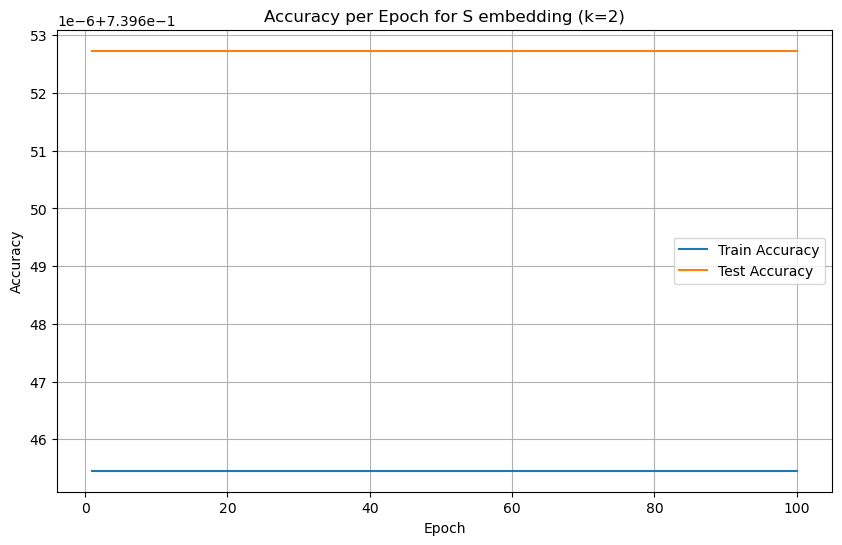

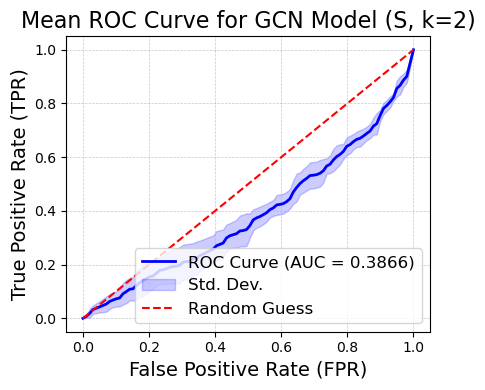

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3866
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 3=======================


5it [07:43, 92.76s/it]


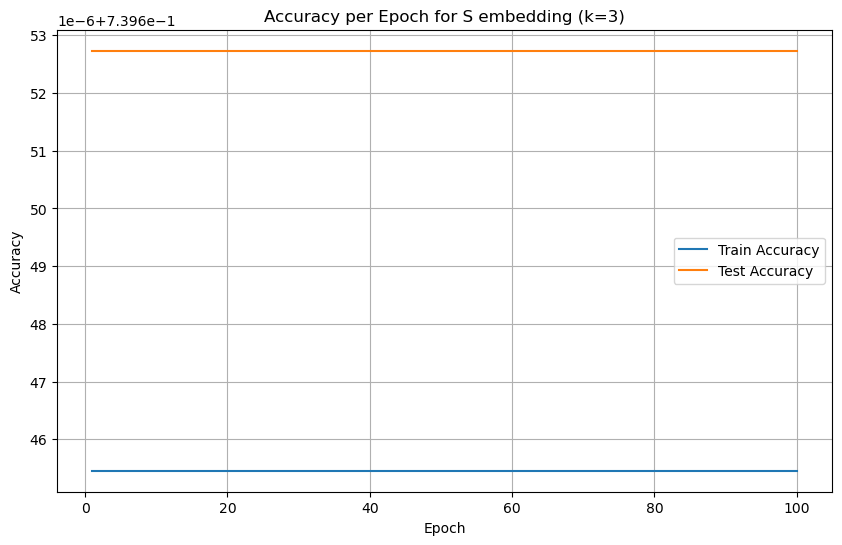

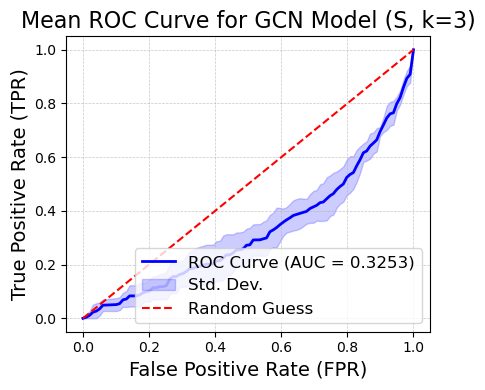

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3253
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 4=======================


5it [07:46, 93.28s/it]


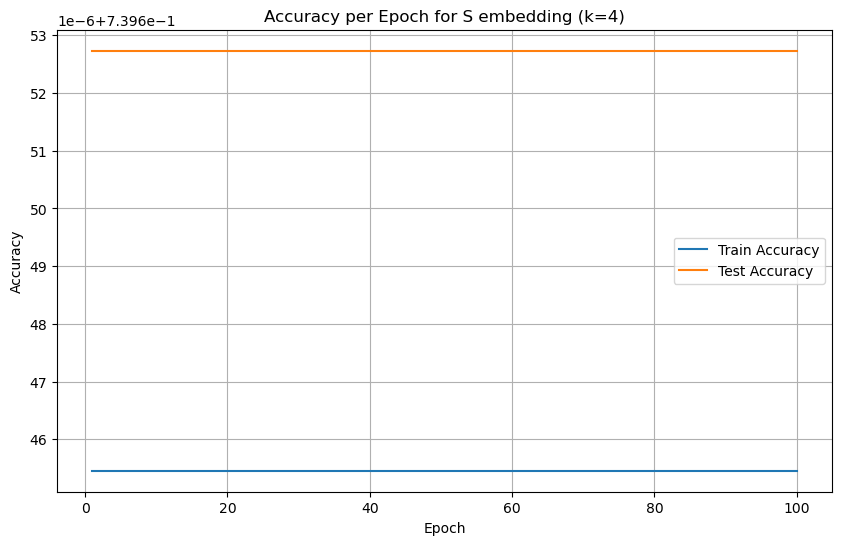

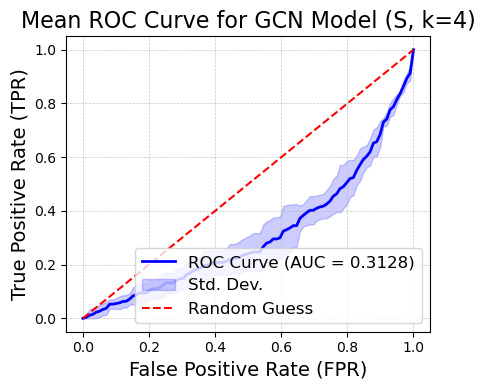

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3128
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 5=======================


5it [07:46, 93.36s/it]


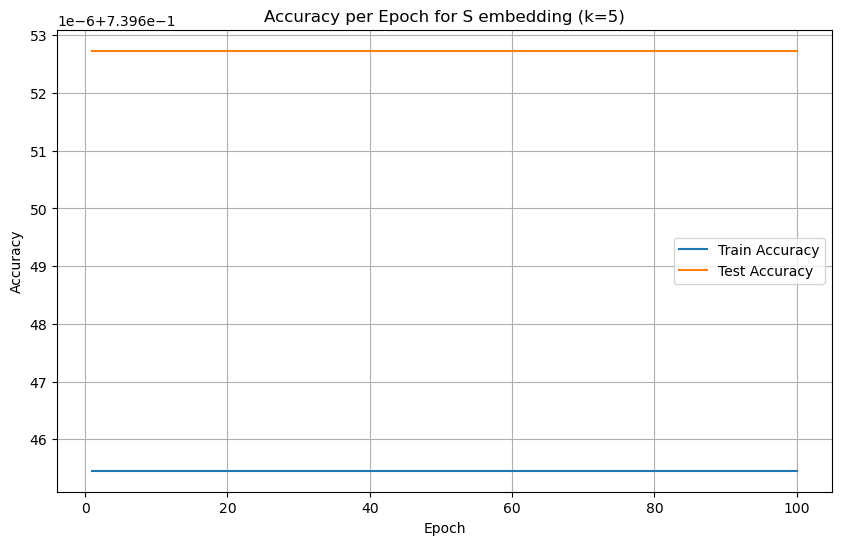

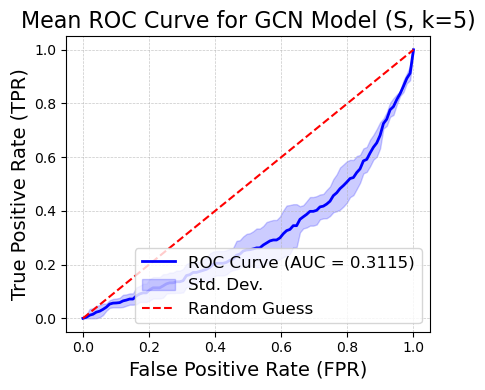

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3115
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 6=======================


5it [07:47, 93.48s/it]


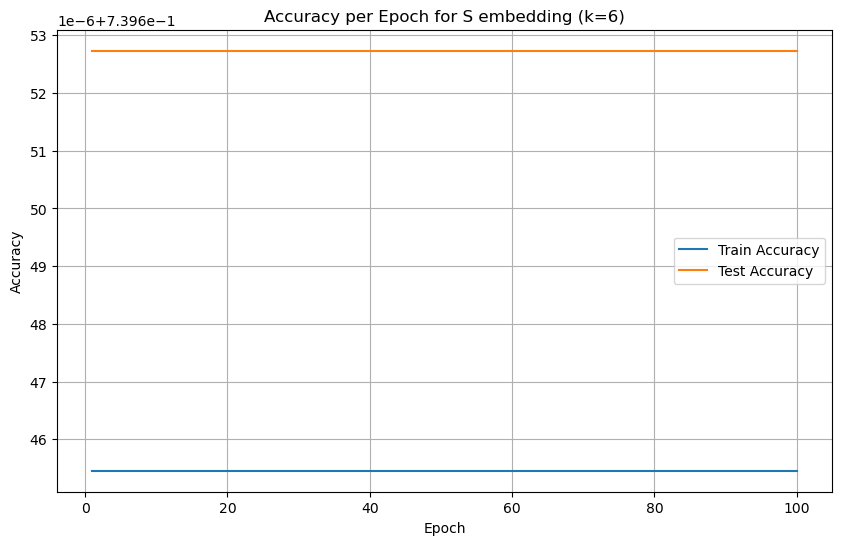

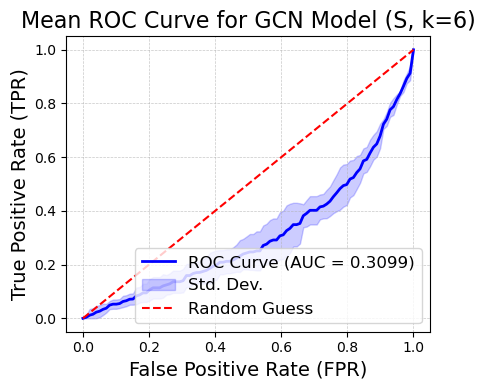

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3099
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 7=======================


5it [07:42, 92.56s/it]


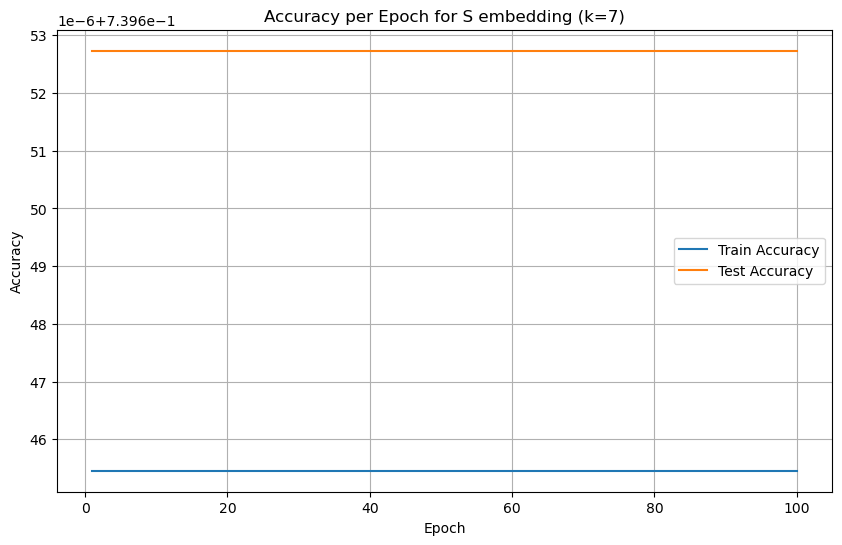

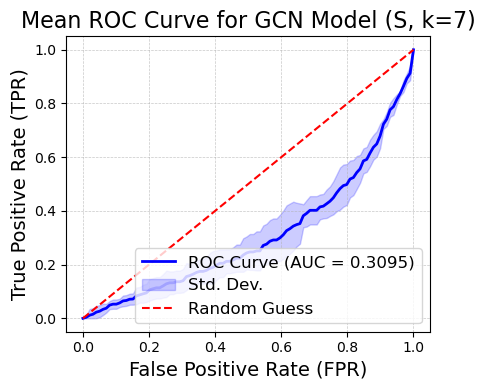

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3095
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 8=======================


5it [07:47, 93.50s/it]


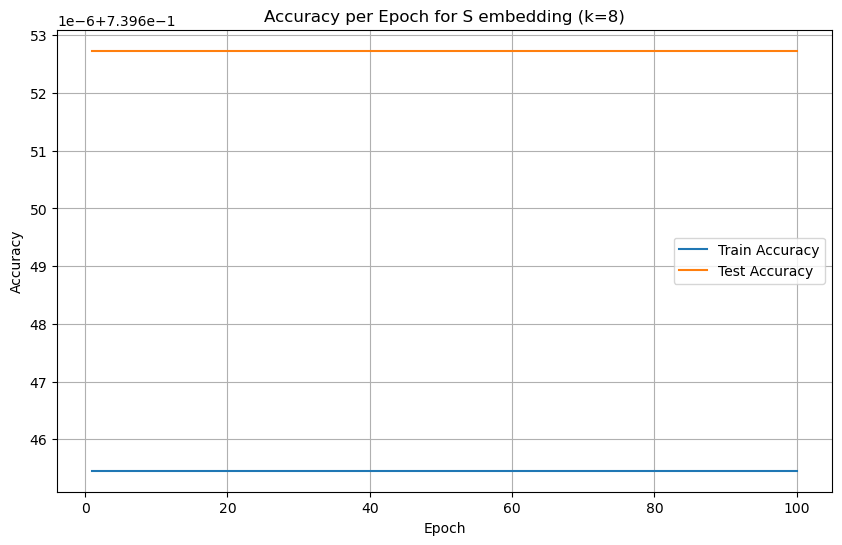

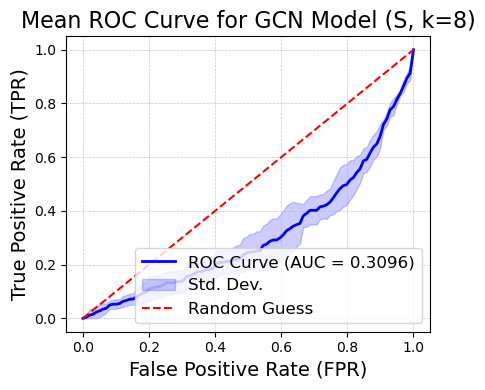

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3096
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 9=======================


5it [07:48, 93.61s/it]


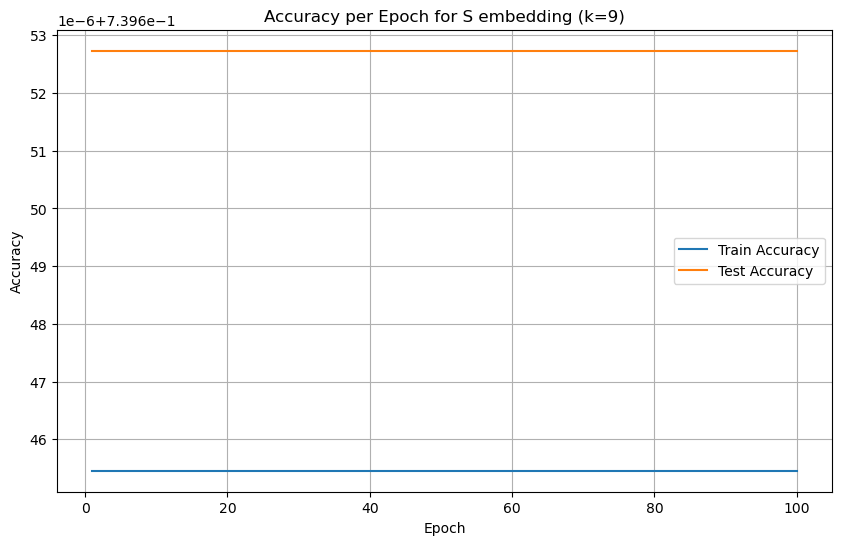

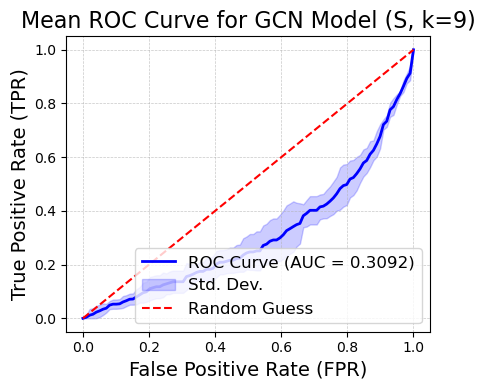

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.3092
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000


In [44]:
input_dim = 2

for k in sorted(ks):
    print(f"==================For {k}=======================")
    splits = kf.split(dataset_S[k])

    train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
    precisions, recalls, npvs, specificities = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs, [0] * num_epochs

    epoch_fprs = [[] for _ in range(num_epochs)]
    epoch_tprs = [[] for _ in range(num_epochs)]
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
        train_dataset = [dataset_S[k][i] for i in train_idx]
        test_dataset = [dataset_S[k][i] for i in test_idx]
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, exclude_keys=['weight'])
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, exclude_keys=['weight'])

        set_seed(42)
        model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)

        for epoch in range(num_epochs):
            loss = train(model, optimizer, criterion, train_loader)
            train_acc = test(model, train_loader)
            test_acc = test(model, test_loader)
            fpr, tpr, _ = test_with_auc(model, test_loader)
            precision = evaluate_with_fixed_threshold_precision(model, test_loader)
            recall = evaluate_with_fixed_threshold_recall(model, test_loader)
            npv = evaluate_with_npv(model, test_loader)
            specificity = evaluate_with_specificity(model, test_loader)

            train_accs[epoch] += train_acc
            test_accs[epoch] += test_acc
            precisions[epoch] += precision
            recalls[epoch] += recall
            npvs[epoch] += npv
            specificities[epoch] += specificity

            epoch_fprs[epoch].append(fpr)
            epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
            epoch_tprs[epoch][-1][0]= 0.0

    mean_train_accs = [acc / K for acc in train_accs]
    mean_test_accs = [acc / K for acc in test_accs]
    mean_precisions = [pre / K for pre in precisions]
    mean_recalls = [recall / K for recall in recalls]
    mean_npvs = [npv / K for npv in npvs]
    mean_specificities = [spec / K for spec in specificities]


    best_mean_accuracy = max(mean_test_accs)
    best_epoch = mean_test_accs.index(best_mean_accuracy)
    mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
    std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
    mean_tpr[-1] = 1.0
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    # Plot accuracy graphs over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch for S embedding (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC Curve for the best epoch
    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'Mean ROC Curve for GCN Model (S, k={k})', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()
        
    print(f"Epoch = {best_epoch}")
    print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
    print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
    print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
    print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")
    print(f"Best mean_npv: {mean_npvs[best_epoch]:.4f}")
    print(f"Best mean_specificity: {mean_specificities[best_epoch]:.4f}")


### Function Type Only (F)

==================For 1=======================


5it [06:57, 83.57s/it]


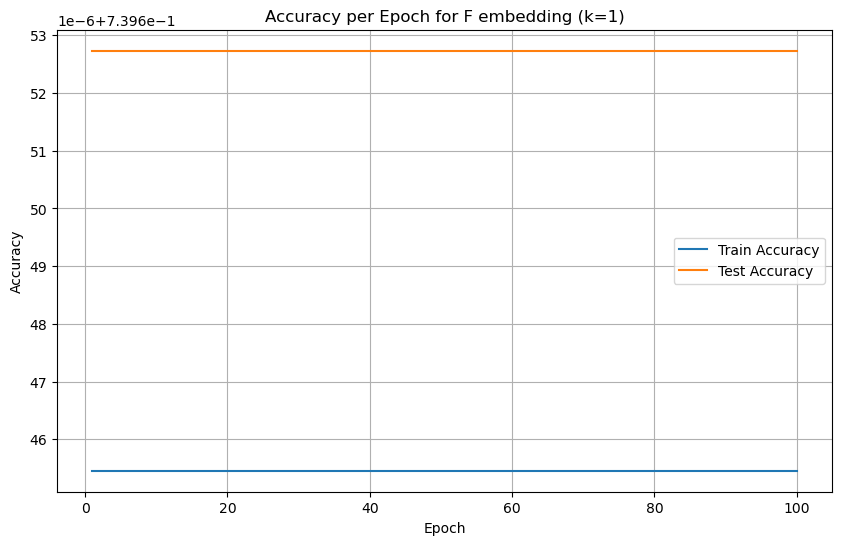

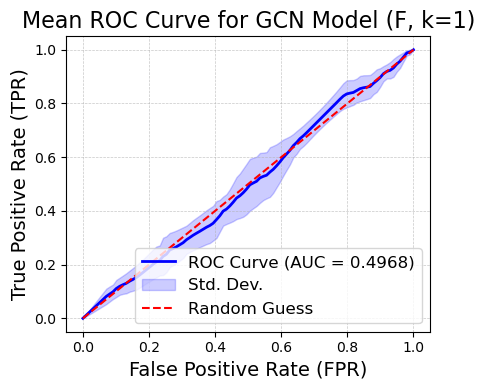

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4968
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 2=======================


5it [07:31, 90.32s/it]


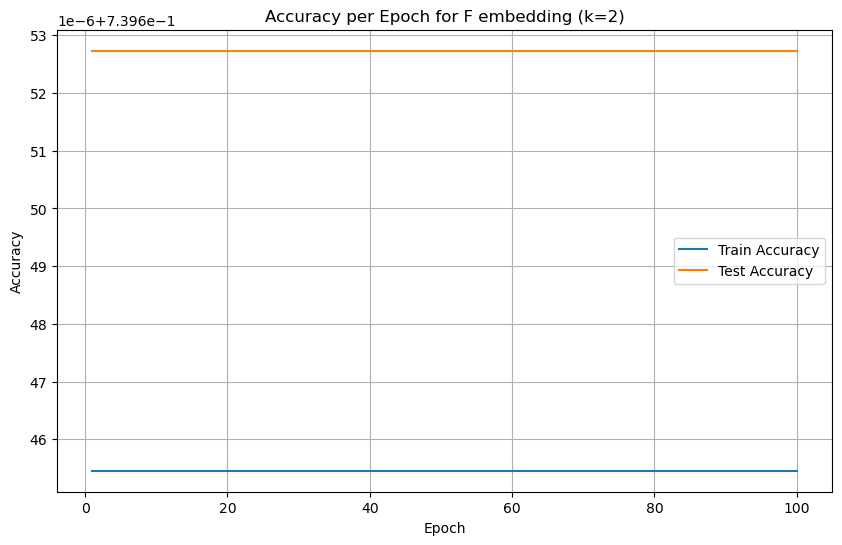

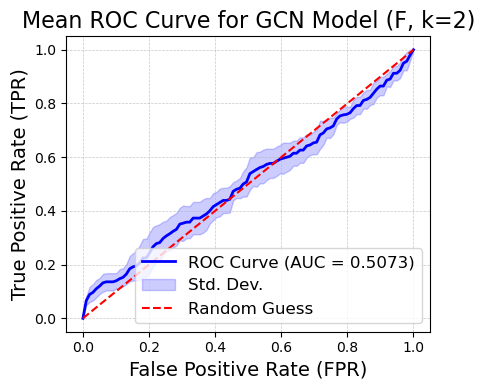

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.5073
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 3=======================


5it [07:43, 92.77s/it]


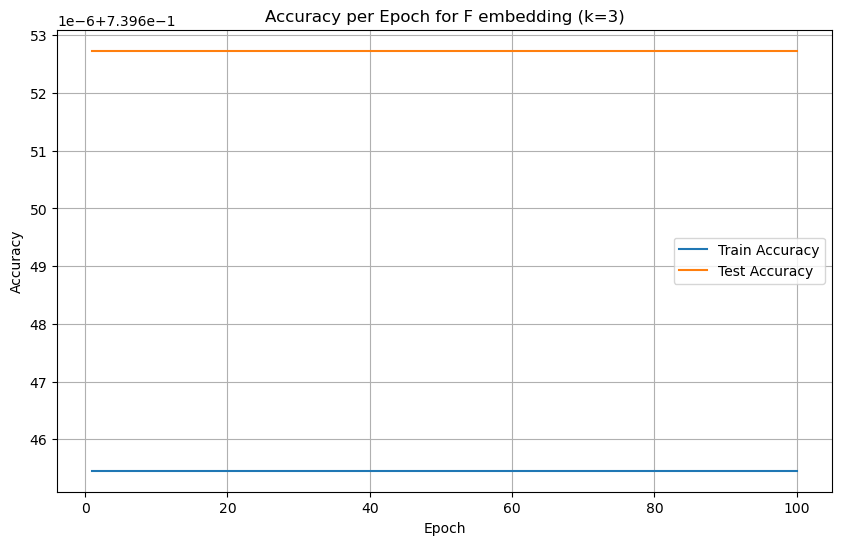

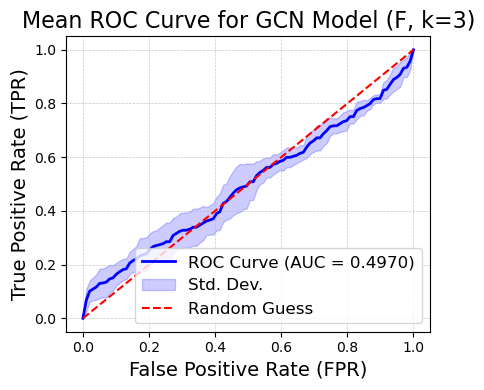

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4970
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 4=======================


5it [07:43, 92.62s/it]


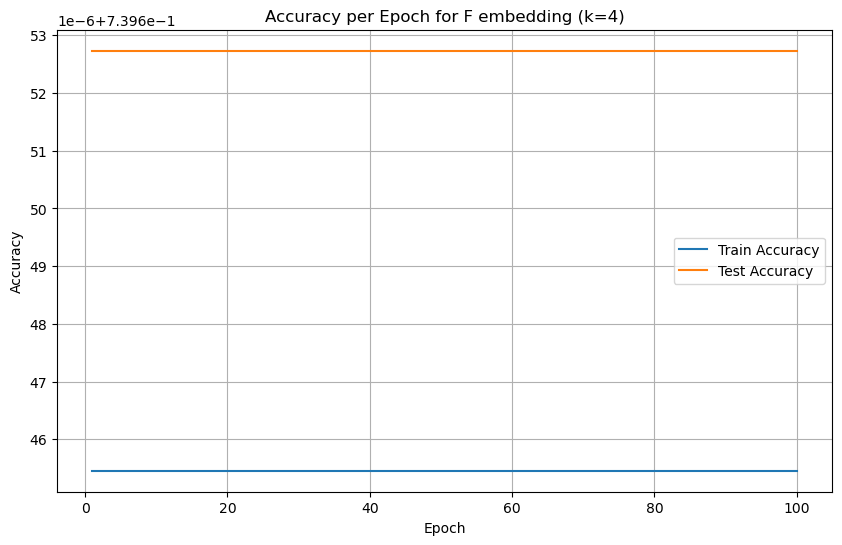

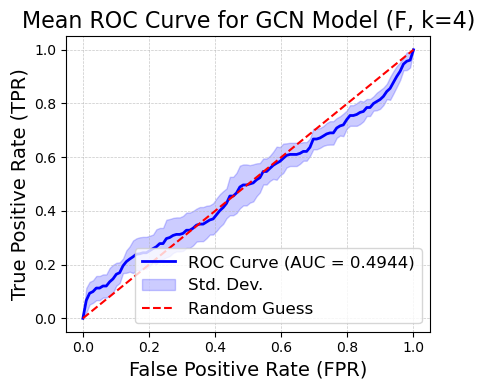

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4944
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 5=======================


5it [07:46, 93.29s/it]


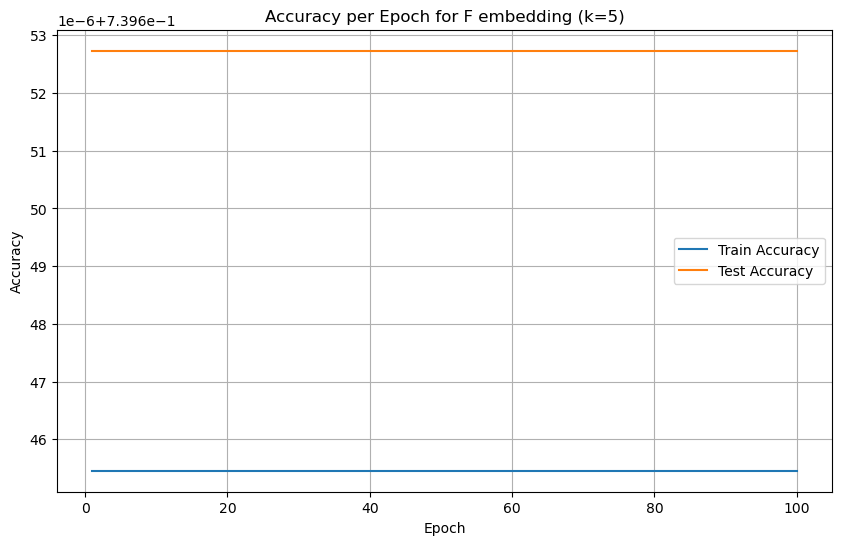

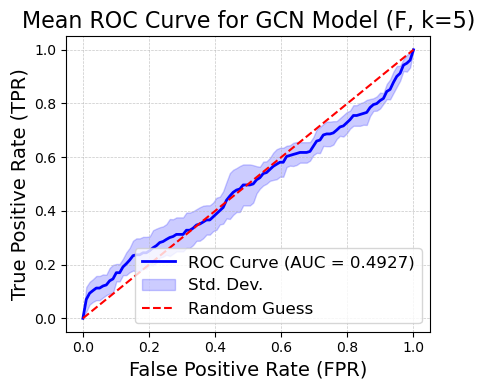

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4927
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 6=======================


5it [07:46, 93.31s/it]


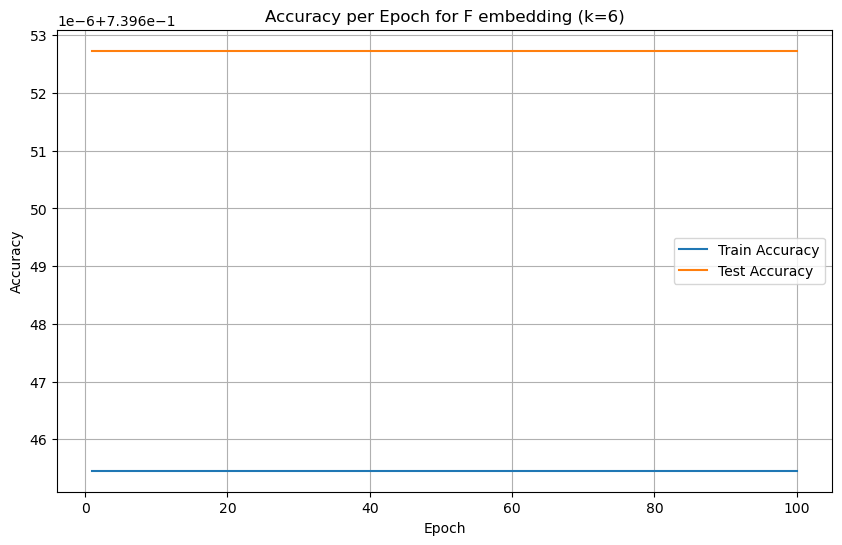

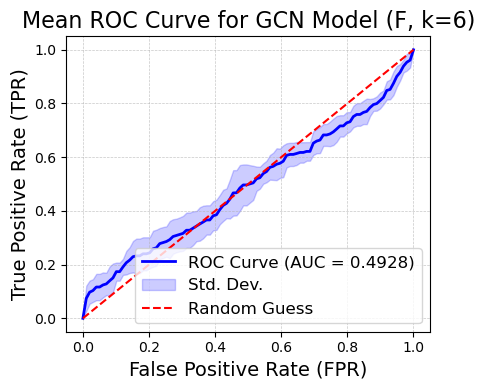

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4928
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 7=======================


5it [07:47, 93.42s/it]


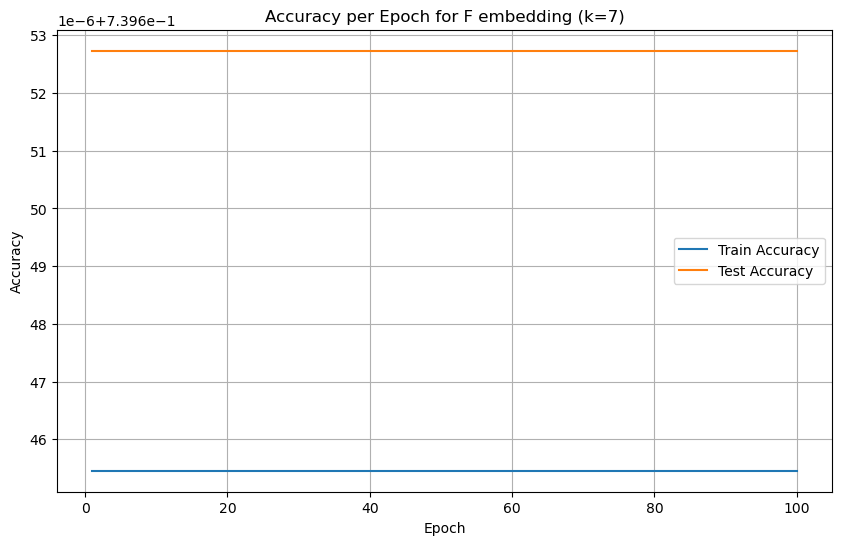

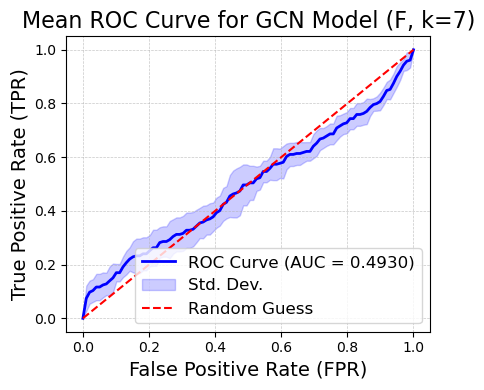

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4930
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 8=======================


5it [07:47, 93.48s/it]


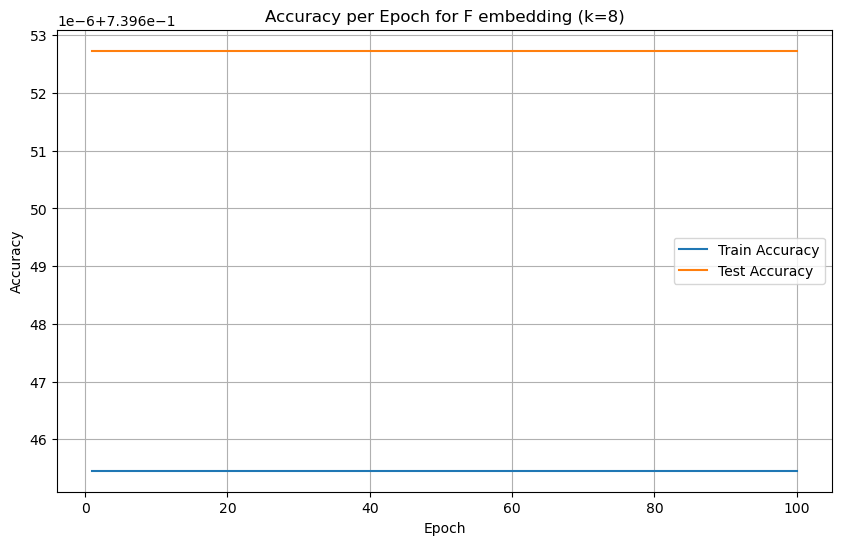

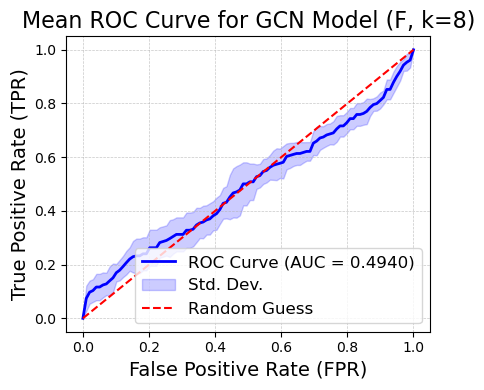

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4940
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 9=======================


5it [07:46, 93.36s/it]


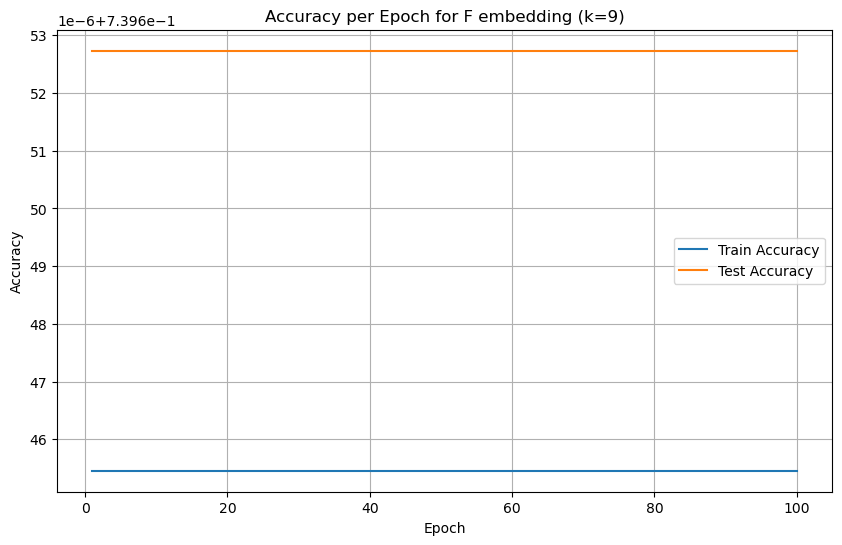

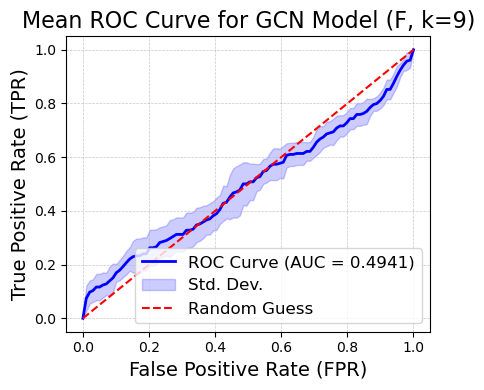

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4941
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000


In [45]:
input_dim = 2

for k in sorted(ks):
    print(f"==================For {k}=======================")
    splits = kf.split(dataset_F[k])

    train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
    precisions, recalls, npvs, specificities = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs, [0] * num_epochs

    epoch_fprs = [[] for _ in range(num_epochs)]
    epoch_tprs = [[] for _ in range(num_epochs)]
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
        train_dataset = [dataset_F[k][i] for i in train_idx]
        test_dataset = [dataset_F[k][i] for i in test_idx]
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, exclude_keys=['weight'])
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, exclude_keys=['weight'])

        set_seed(42)
        model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)

        for epoch in range(num_epochs):
            loss = train(model, optimizer, criterion, train_loader)
            train_acc = test(model, train_loader)
            test_acc = test(model, test_loader)
            fpr, tpr, _ = test_with_auc(model, test_loader)
            precision = evaluate_with_fixed_threshold_precision(model, test_loader)
            recall = evaluate_with_fixed_threshold_recall(model, test_loader)
            npv = evaluate_with_npv(model, test_loader)
            specificity = evaluate_with_specificity(model, test_loader)

            train_accs[epoch] += train_acc
            test_accs[epoch] += test_acc
            precisions[epoch] += precision
            recalls[epoch] += recall
            npvs[epoch] += npv
            specificities[epoch] += specificity

            epoch_fprs[epoch].append(fpr)
            epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
            epoch_tprs[epoch][-1][0]= 0.0

    mean_train_accs = [acc / K for acc in train_accs]
    mean_test_accs = [acc / K for acc in test_accs]
    mean_precisions = [pre / K for pre in precisions]
    mean_recalls = [recall / K for recall in recalls]
    mean_npvs = [npv / K for npv in npvs]
    mean_specificities = [spec / K for spec in specificities]


    best_mean_accuracy = max(mean_test_accs)
    best_epoch = mean_test_accs.index(best_mean_accuracy)
    mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
    std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
    mean_tpr[-1] = 1.0
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    # Plot accuracy graphs over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch for F embedding (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC Curve for the best epoch
    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'Mean ROC Curve for GCN Model (F, k={k})', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()
        
    print(f"Epoch = {best_epoch}")
    print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
    print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
    print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
    print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")
    print(f"Best mean_npv: {mean_npvs[best_epoch]:.4f}")
    print(f"Best mean_specificity: {mean_specificities[best_epoch]:.4f}")


### Function Type and Arguments (F+A)

==================For 1=======================


5it [06:54, 82.88s/it]


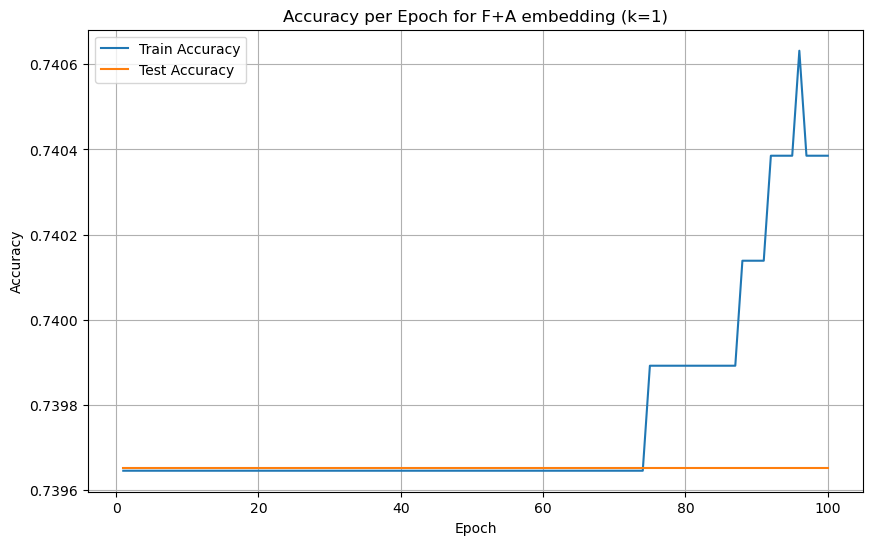

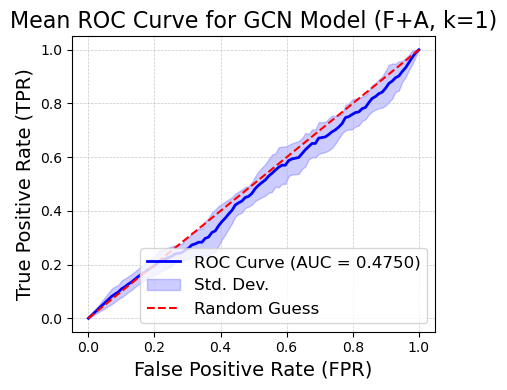

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4750
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 2=======================


5it [07:36, 91.36s/it]


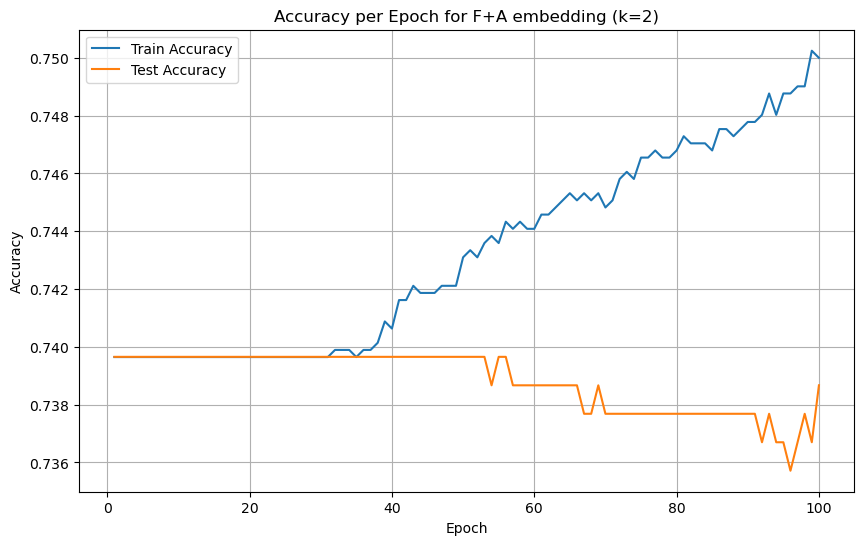

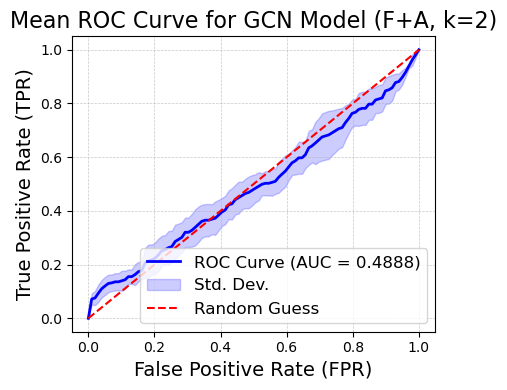

Epoch = 0
Best_mean_accuracy: 0.7397
Best mean_roc_auc: 0.4888
Best mean_precision: 0.0000
Best mean_recall: 0.0000
Best mean_npv: 0.7397
Best mean_specificity: 1.0000
==================For 3=======================


5it [07:45, 93.09s/it]


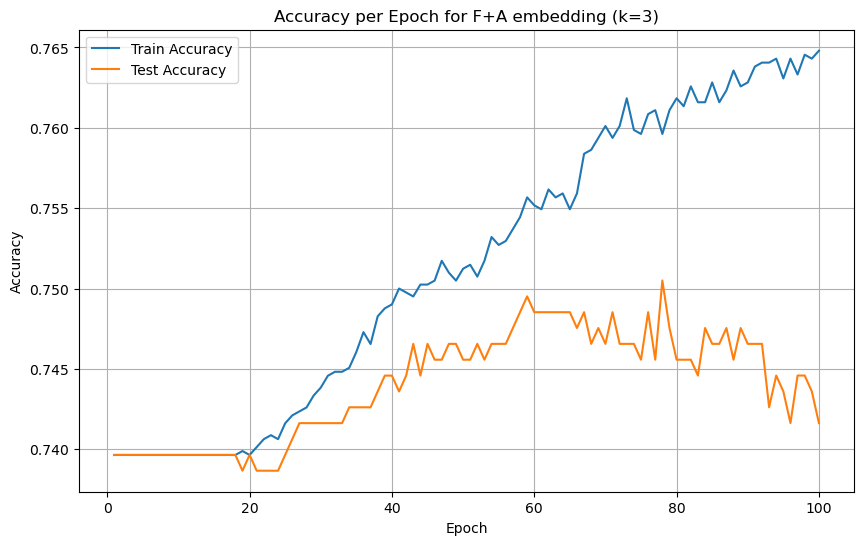

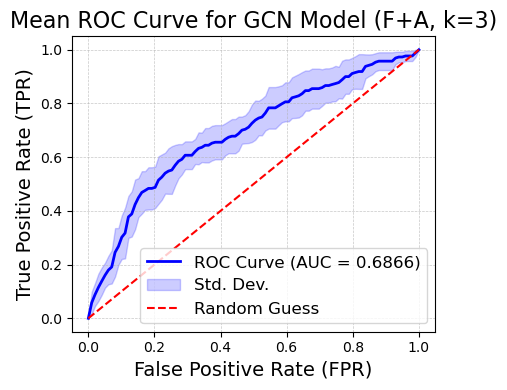

Epoch = 77
Best_mean_accuracy: 0.7505
Best mean_roc_auc: 0.6866
Best mean_precision: 0.9000
Best mean_recall: 0.0495
Best mean_npv: 0.7488
Best mean_specificity: 0.9973
==================For 4=======================


5it [07:48, 93.68s/it]


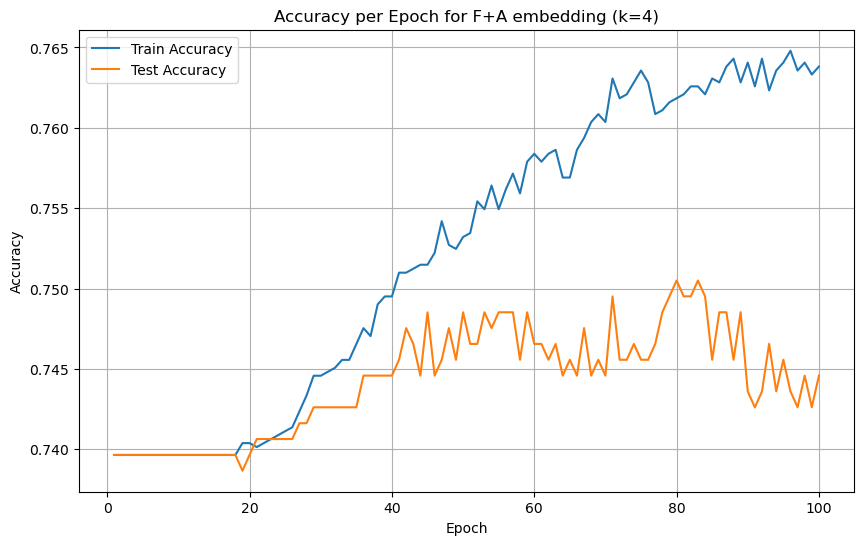

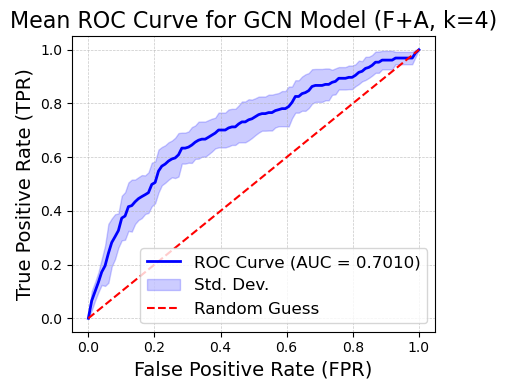

Epoch = 79
Best_mean_accuracy: 0.7505
Best mean_roc_auc: 0.7010
Best mean_precision: 0.6820
Best mean_recall: 0.0800
Best mean_npv: 0.7529
Best mean_specificity: 0.9866
==================For 5=======================


5it [07:46, 93.37s/it]


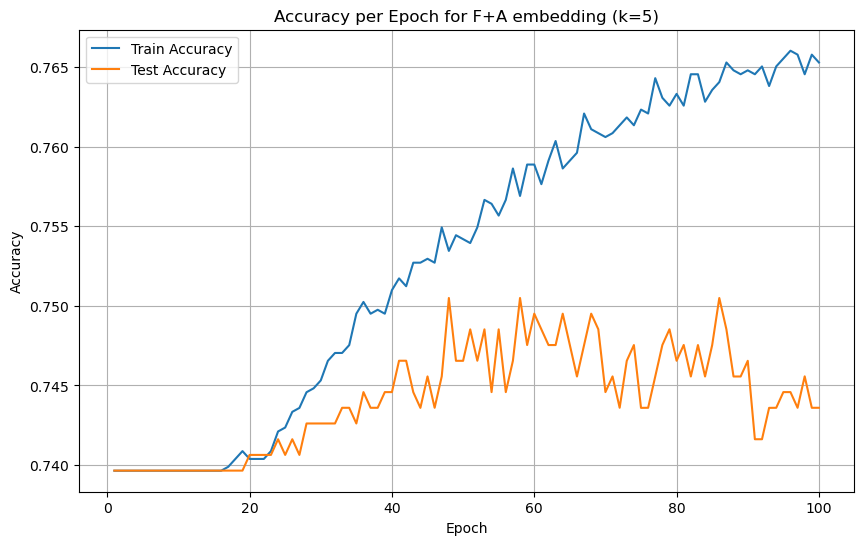

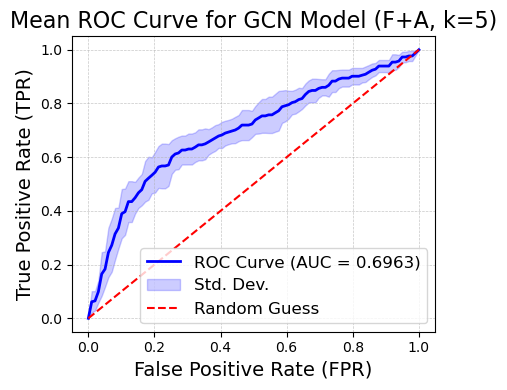

Epoch = 47
Best_mean_accuracy: 0.7505
Best mean_roc_auc: 0.6963
Best mean_precision: 0.8000
Best mean_recall: 0.0537
Best mean_npv: 0.7493
Best mean_specificity: 0.9959
==================For 6=======================


5it [07:45, 93.18s/it]


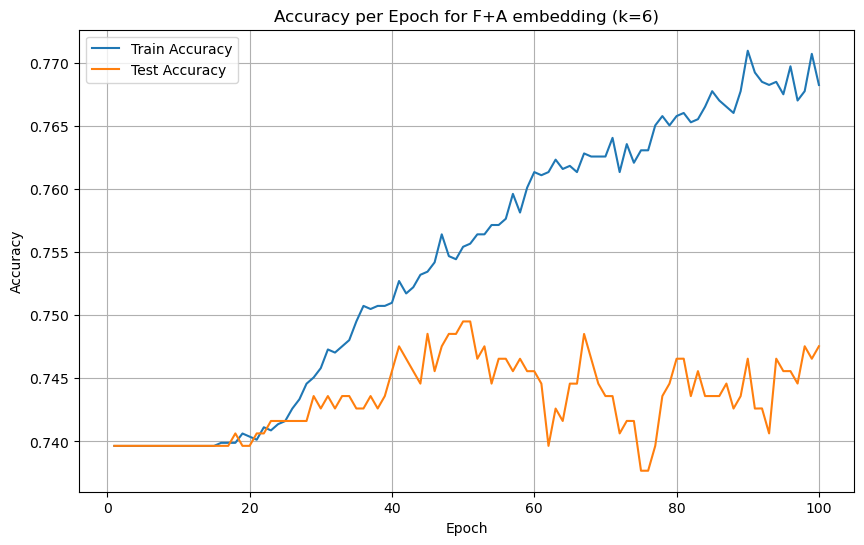

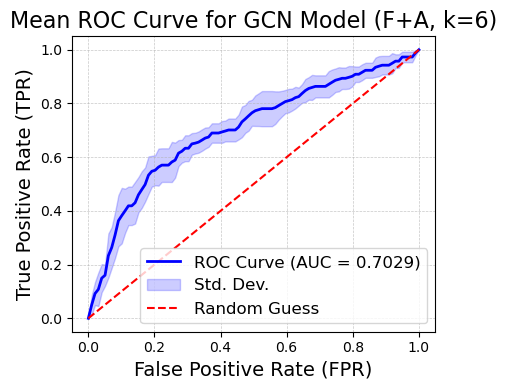

Epoch = 49
Best_mean_accuracy: 0.7495
Best mean_roc_auc: 0.7029
Best mean_precision: 0.8333
Best mean_recall: 0.0495
Best mean_npv: 0.7485
Best mean_specificity: 0.9959
==================For 7=======================


5it [07:47, 93.59s/it]


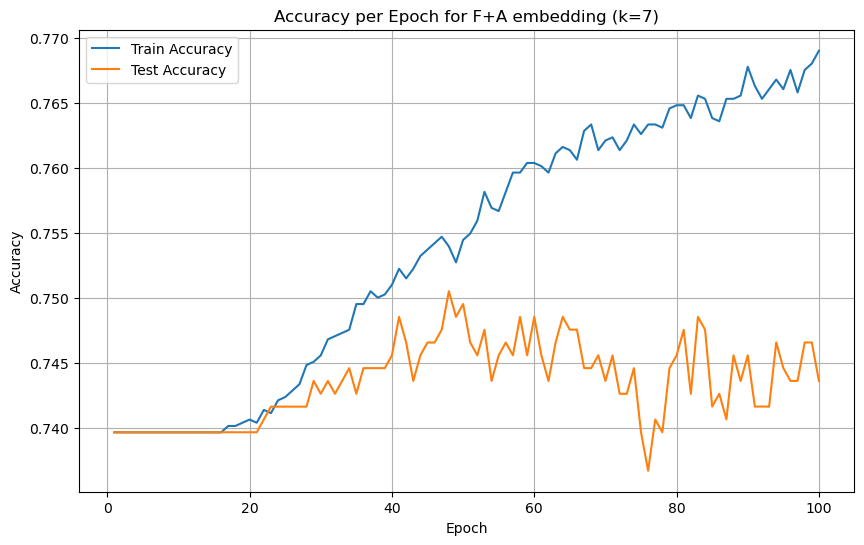

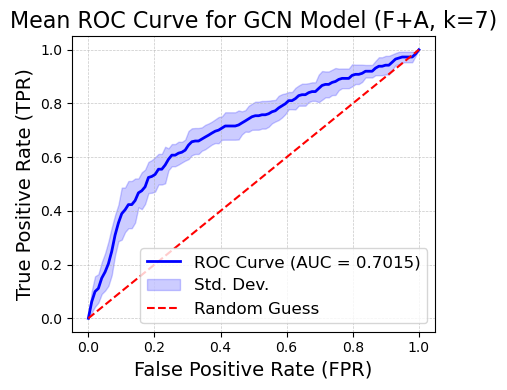

Epoch = 47
Best_mean_accuracy: 0.7505
Best mean_roc_auc: 0.7015
Best mean_precision: 0.9000
Best mean_recall: 0.0495
Best mean_npv: 0.7488
Best mean_specificity: 0.9973
==================For 8=======================


5it [07:47, 93.53s/it]


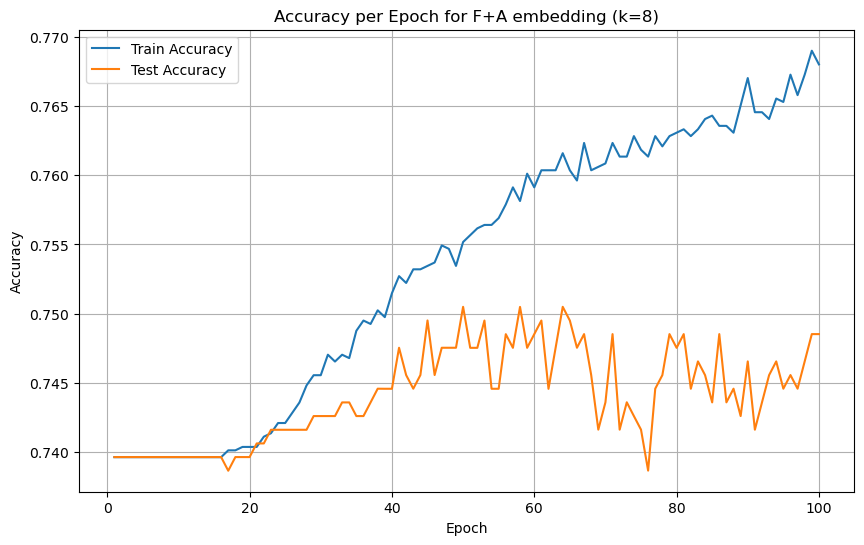

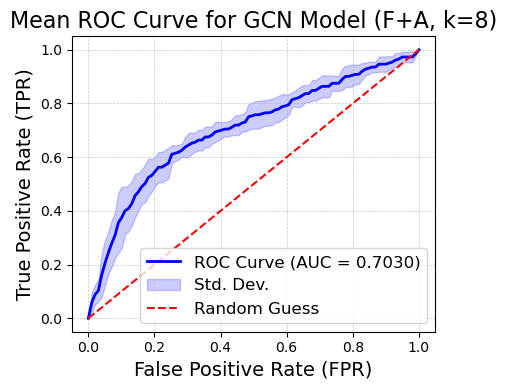

Epoch = 49
Best_mean_accuracy: 0.7505
Best mean_roc_auc: 0.7030
Best mean_precision: 0.9000
Best mean_recall: 0.0495
Best mean_npv: 0.7488
Best mean_specificity: 0.9973
==================For 9=======================


5it [07:48, 93.61s/it]


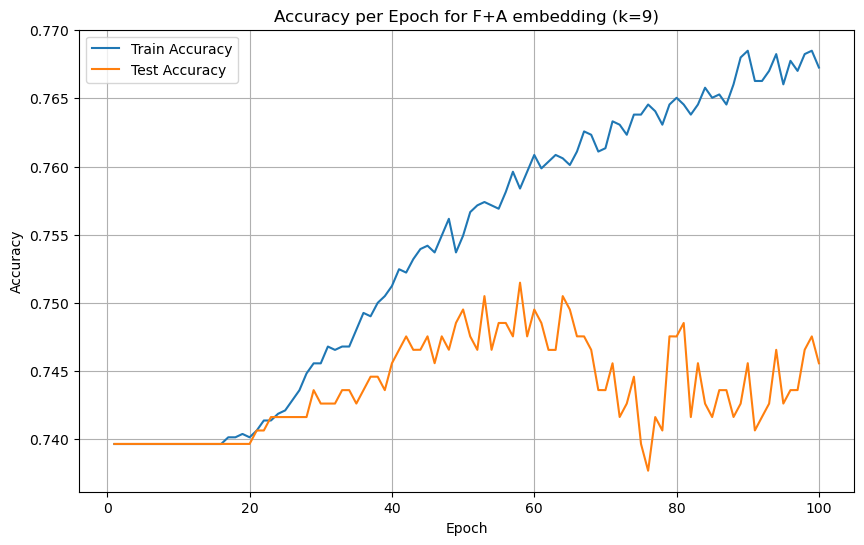

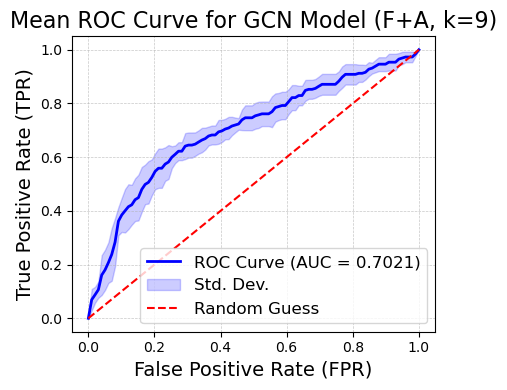

Epoch = 57
Best_mean_accuracy: 0.7515
Best mean_roc_auc: 0.7021
Best mean_precision: 0.7381
Best mean_recall: 0.0649
Best mean_npv: 0.7511
Best mean_specificity: 0.9933


In [46]:
input_dim = 50

for k in sorted(ks):
    print(f"==================For {k}=======================")
    splits = kf.split(dataset_FA[k])

    train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
    precisions, recalls, npvs, specificities = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs, [0] * num_epochs

    epoch_fprs = [[] for _ in range(num_epochs)]
    epoch_tprs = [[] for _ in range(num_epochs)]
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
        train_dataset = [dataset_FA[k][i] for i in train_idx]
        test_dataset = [dataset_FA[k][i] for i in test_idx]
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, exclude_keys=['weight'])
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, exclude_keys=['weight'])

        set_seed(42)
        model = GCN(input_dim, hidden_dim, output_dim, dropout_p, num_layer).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)

        for epoch in range(num_epochs):
            loss = train(model, optimizer, criterion, train_loader)
            train_acc = test(model, train_loader)
            test_acc = test(model, test_loader)
            fpr, tpr, _ = test_with_auc(model, test_loader)
            precision = evaluate_with_fixed_threshold_precision(model, test_loader)
            recall = evaluate_with_fixed_threshold_recall(model, test_loader)
            npv = evaluate_with_npv(model, test_loader)
            specificity = evaluate_with_specificity(model, test_loader)

            train_accs[epoch] += train_acc
            test_accs[epoch] += test_acc
            precisions[epoch] += precision
            recalls[epoch] += recall
            npvs[epoch] += npv
            specificities[epoch] += specificity

            epoch_fprs[epoch].append(fpr)
            epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))
            epoch_tprs[epoch][-1][0]= 0.0

    mean_train_accs = [acc / K for acc in train_accs]
    mean_test_accs = [acc / K for acc in test_accs]
    mean_precisions = [pre / K for pre in precisions]
    mean_recalls = [recall / K for recall in recalls]
    mean_npvs = [npv / K for npv in npvs]
    mean_specificities = [spec / K for spec in specificities]


    best_mean_accuracy = max(mean_test_accs)
    best_epoch = mean_test_accs.index(best_mean_accuracy)
    mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
    std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
    mean_tpr[-1] = 1.0
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    # Plot accuracy graphs over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch for F+A embedding (k={k})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC Curve for the best epoch
    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'Mean ROC Curve for GCN Model (F+A, k={k})', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()
        
    print(f"Epoch = {best_epoch}")
    print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
    print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
    print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
    print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")
    print(f"Best mean_npv: {mean_npvs[best_epoch]:.4f}")
    print(f"Best mean_specificity: {mean_specificities[best_epoch]:.4f}")